In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nse-stock-historical-price-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5371901%2F8929950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240716%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240716T045621Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da3bdaa84af4c1f8e2bececca5ddb5c0de93b78a40a76c6a97633e6803ce5f74659530868f045bd0bb104bd86fe14768f394b3f57bfbdaf949c854fad6ed06bfbe78fc1edb7bda245b1bda13b70fd48e1c7207cbbbab550a5d5a81ce47529a437b2588c70c36162e4eb499426d19ad50c737cc3e4461cecc8ef9114ae6c09b206b5575d202e12e889fe18190a4630644971cda6b71464939577715c278590d9d2b572923193447e1f653051e2fd191da0e88e2aeda2f51c410154422aa1283dbdaca4982ddb7d396a9ace7713ddac666bdeb51cc16b4a3631b63383ae4b6a12026a339f386c38e7bb72d0f78ecd05ec30c3235e5cfc8fec425e04714acf426d91'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21490351 bytes downloaded
Downloaded and uncompressed: nse-stock-historical-price-data
Data source import complete.


# 1. Data Preprocessing and Exploratory Data Analysis
Clean the dataset, handling any missing values or outliers
Perform basic statistical analysis on the stock prices and volumes
Visualize the price trends of the first 10 stocks.


In [3]:
import pandas as pd
data = pd.read_csv('/kaggle/input/nse-stock-historical-price-data/nse_all_stock_data (1).csv')

In [4]:
data.head()

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,LICI,ITC,...,COOLCAPS,ALLETEC,20MICRONS,VIKASECO,ORIENTBELL,DONEAR,CAREERP,INTLCONV,SHREEPUSHK,PRITIKAUTO
0,1991-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.shape

(8470, 1418)

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
data['Date']

0      1991-01-02
1      1991-01-03
2      1991-01-04
3      1991-01-07
4      1991-01-08
          ...    
8465   2024-07-01
8466   2024-07-02
8467   2024-07-03
8468   2024-07-04
8469   2024-07-05
Name: Date, Length: 8470, dtype: datetime64[ns]

In [10]:
data.head()

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,LICI,ITC,...,COOLCAPS,ALLETEC,20MICRONS,VIKASECO,ORIENTBELL,DONEAR,CAREERP,INTLCONV,SHREEPUSHK,PRITIKAUTO
0,1991-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
missing_values =  data.isnull().sum()

In [13]:
missing_percentage = (missing_values/len(data))*100

In [18]:
data_cleaned = data.loc[:,missing_percentage<=50]

In [15]:
missing_values

Date             0
RELIANCE      1310
TCS           3034
HDFCBANK      1307
ICICIBANK     3005
              ... 
DONEAR        4147
CAREERP       5081
INTLCONV      7778
SHREEPUSHK    6297
PRITIKAUTO    7753
Length: 1418, dtype: int64

In [16]:
missing_percentage

Date           0.000000
RELIANCE      15.466352
TCS           35.820543
HDFCBANK      15.430933
ICICIBANK     35.478158
                ...    
DONEAR        48.961039
CAREERP       59.988194
INTLCONV      91.829988
SHREEPUSHK    74.344746
PRITIKAUTO    91.534829
Length: 1418, dtype: float64

In [17]:
data_cleaned

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,...,JETAIRWAYS,JINDALPHOT,HCL-INSYS,ASMS,NAGAFERT,GEECEE,REMSONSIND,PTL,ORIENTBELL,DONEAR
0,1991-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,2024-07-01,3120.300049,3978.199951,1705.199951,1211.849976,1454.000000,841.950012,1590.800049,429.049988,2505.100098,...,42.650002,912.000000,16.850000,20.35,12.54,390.950012,203.500000,46.189999,402.799988,134.960007
8466,2024-07-02,3130.350098,4017.399902,1730.599976,1190.599976,1418.949951,826.150024,1621.050049,425.500000,2485.149902,...,42.080002,924.299988,16.920000,20.75,12.16,386.700012,208.059998,46.240002,409.799988,130.729996
8467,2024-07-03,3104.850098,3965.250000,1768.650024,1201.599976,1419.849976,839.950012,1627.400024,428.299988,2510.350098,...,42.040001,913.049988,17.010000,21.16,12.45,387.200012,204.649994,46.270000,429.350006,132.220001
8468,2024-07-04,3108.050049,4020.949951,1727.150024,1233.000000,1423.050049,839.299988,1650.650024,429.049988,2495.949951,...,41.669998,890.200012,16.840000,21.58,12.41,388.700012,214.600006,46.119999,428.750000,131.360001


In [19]:
data_cleaned_info = data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8470 entries, 0 to 8469
Columns: 612 entries, Date to DONEAR
dtypes: datetime64[ns](1), float64(611)
memory usage: 39.5 MB


In [20]:
data_cleaned.isnull().sum()

Date             0
RELIANCE      1310
TCS           3034
HDFCBANK      1307
ICICIBANK     3005
              ... 
GEECEE        4094
REMSONSIND    3003
PTL           4172
ORIENTBELL    4183
DONEAR        4147
Length: 612, dtype: int64

In [21]:
data_filled = data_cleaned.bfill()

In [23]:
data_filled

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,...,JETAIRWAYS,JINDALPHOT,HCL-INSYS,ASMS,NAGAFERT,GEECEE,REMSONSIND,PTL,ORIENTBELL,DONEAR
0,1991-01-02,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
1,1991-01-03,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
2,1991-01-04,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
3,1991-01-07,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
4,1991-01-08,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,2024-07-01,3120.300049,3978.199951,1705.199951,1211.849976,1454.000000,841.950012,1590.800049,429.049988,2505.100098,...,42.650002,912.000000,16.850000,20.35,12.54,390.950012,203.500000,46.189999,402.799988,134.960007
8466,2024-07-02,3130.350098,4017.399902,1730.599976,1190.599976,1418.949951,826.150024,1621.050049,425.500000,2485.149902,...,42.080002,924.299988,16.920000,20.75,12.16,386.700012,208.059998,46.240002,409.799988,130.729996
8467,2024-07-03,3104.850098,3965.250000,1768.650024,1201.599976,1419.849976,839.950012,1627.400024,428.299988,2510.350098,...,42.040001,913.049988,17.010000,21.16,12.45,387.200012,204.649994,46.270000,429.350006,132.220001
8468,2024-07-04,3108.050049,4020.949951,1727.150024,1233.000000,1423.050049,839.299988,1650.650024,429.049988,2495.949951,...,41.669998,890.200012,16.840000,21.58,12.41,388.700012,214.600006,46.119999,428.750000,131.360001


In [24]:
data_filled.isnull().sum()

Date          0
RELIANCE      0
TCS           0
HDFCBANK      0
ICICIBANK     0
             ..
GEECEE        0
REMSONSIND    0
PTL           0
ORIENTBELL    0
DONEAR        0
Length: 612, dtype: int64

In [28]:
def identify_outliers_iqr(df, column):
    Q1 = data_filled[column].quantile(0.25)
    Q3 = data_filled[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data_filled[(df[column] < lower_bound) | (data_filled[column] > upper_bound)]
    return outliers

# Apply the function to each stock price column
outliers_iqr = {}
for column in data_filled.columns:
    if column != 'Date':
        outliers_iqr[column] = identify_outliers_iqr(data_filled, column)


In [40]:
identify_outliers_iqr(data_filled,column)

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,...,JETAIRWAYS,JINDALPHOT,HCL-INSYS,ASMS,NAGAFERT,GEECEE,REMSONSIND,PTL,ORIENTBELL,DONEAR


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RELIANCE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RELIANCE'}, axis=1)
              .sort_values('RELIANCE', ascending=True))
  xs = counted['RELIANCE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('RELIANCE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RELIANCE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['TCS']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TCS'}, axis=1)
              .sort_values('TCS', ascending=True))
  xs = counted['TCS']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('TCS', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('TCS')
_ = plt.ylabel('count()')

In [41]:
# Calculate Q1, Q3, and IQR for each stock price column
Q1 = data_filled.quantile(0.25)
Q3 = data_filled.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers at the lower and upper bounds
data_cleaned = data_filled.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Check the cleaned data
data_cleaned_info = data_cleaned.info()
data_cleaned_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8470 entries, 0 to 8469
Columns: 612 entries, Date to DONEAR
dtypes: datetime64[ns](1), float64(40), object(571)
memory usage: 39.5+ MB


In [26]:
data_cleaned.shape

(8470, 612)

In [42]:
basic_stats = data_filled.describe()

In [44]:
first_10_stocks=data_filled.columns[1:11]

In [45]:
data_cleaned_info=data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8470 entries, 0 to 8469
Columns: 612 entries, Date to DONEAR
dtypes: datetime64[ns](1), float64(611)
memory usage: 39.5 MB


In [46]:
basic_stats

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,...,JETAIRWAYS,JINDALPHOT,HCL-INSYS,ASMS,NAGAFERT,GEECEE,REMSONSIND,PTL,ORIENTBELL,DONEAR
count,8470,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,...,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000
mean,2007-07-11 12:40:37.969303296,514.448543,798.467475,370.661868,200.478550,237.963422,162.517726,363.667733,114.127340,648.985285,...,795.563177,118.832691,54.664238,76.625256,13.908737,95.317461,14.728617,16.544192,122.100184,130.458937
min,1991-01-02 00:00:00,10.975116,35.474998,2.435000,20.100000,9.350544,13.346102,0.763183,4.182222,61.805000,...,13.650000,7.950000,3.350000,0.500000,2.600000,24.150000,2.020000,3.275000,14.000000,8.900000
25%,1999-02-12 18:00:00,25.584803,39.700001,7.496250,25.127272,15.681876,21.329467,19.350976,14.392500,144.949997,...,314.725006,70.050003,19.822678,12.600000,6.750000,84.300003,5.270000,10.030000,69.550003,31.350000
50%,2007-05-09 12:00:00,298.363907,216.287498,99.955002,113.527271,251.631027,110.849632,197.207817,58.183334,237.464996,...,770.849976,121.370781,19.822678,110.750000,8.650000,93.849998,9.400000,10.030000,69.550003,205.699997
75%,2015-12-06 06:00:00,497.448433,1236.475037,535.462479,256.681824,346.223610,253.587505,496.924988,216.283337,851.274994,...,1304.199951,121.370781,64.520485,110.750000,22.450001,93.849998,9.900000,19.275000,117.000000,214.649994
max,2024-07-05 00:00:00,3177.250000,4219.250000,1768.650024,1233.400024,1475.800049,905.650024,1939.500000,492.149994,2812.449951,...,1375.099976,924.299988,282.798248,283.500000,87.000000,401.250000,214.600006,84.900002,806.200012,236.149994
std,NaN,719.892388,1096.192470,510.729195,249.746445,254.427921,167.137092,457.214896,120.799684,794.411787,...,502.799105,101.980640,56.472196,55.408460,10.745623,41.647104,24.912700,12.051067,124.374667,88.591179


In [47]:
import matplotlib.pyplot as plt
import seaborn as  sns

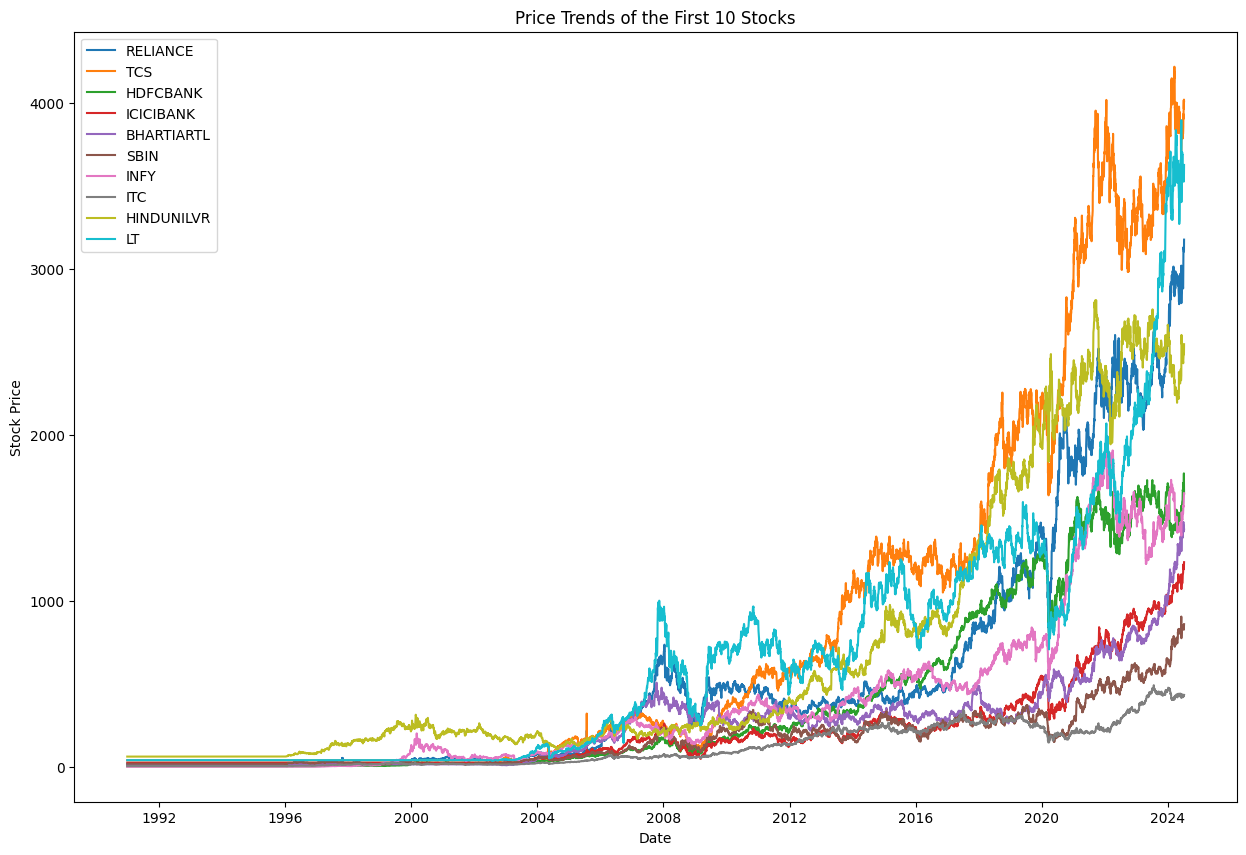

In [48]:
plt.figure(figsize=(15,10))
for stock in first_10_stocks:
    plt.plot(data_filled['Date'],data_filled[stock],label=stock)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Price Trends of the First 10 Stocks')
plt.legend()
plt.show()

# 2.Correlation Analysis
Create a correlation matrix of stock returns
Identify the most correlated pairs of stocks
Visualize the correlations using a heatmap


In [52]:
data_filled[first_10_stocks]

,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,LT
0,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
1,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
2,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
3,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
4,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
...,...,...,...,...,...,...,...,...,...,...
8465,3120.300049,3978.199951,1705.199951,1211.849976,1454.000000,841.950012,1590.800049,429.049988,2505.100098,3526.550049
8466,3130.350098,4017.399902,1730.599976,1190.599976,1418.949951,826.150024,1621.050049,425.500000,2485.149902,3626.500000
8467,3104.850098,3965.250000,1768.650024,1201.599976,1419.849976,839.950012,1627.400024,428.299988,2510.350098,3614.350098
8468,3108.050049,4020.949951,1727.150024,1233.000000,1423.050049,839.299988,1650.650024,429.049988,2495.949951,3573.300049


In [53]:
returns = data_filled[first_10_stocks].pct_change().dropna()

In [54]:
correlation_matrix = returns.corr()

In [55]:
correlation_matrix

,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,LT
RELIANCE,1.000000,0.334207,0.312600,0.323247,0.255303,0.378132,0.243274,0.298100,0.226610,0.214079
TCS,0.334207,1.000000,0.129360,0.198909,0.165686,0.123853,0.208560,0.106972,0.114050,0.121032
HDFCBANK,0.312600,0.129360,1.000000,0.435323,0.246349,0.453585,0.290198,0.319639,0.257731,0.289285
ICICIBANK,0.323247,0.198909,0.435323,1.000000,0.358264,0.522189,0.224409,0.246300,0.215677,0.428387
BHARTIARTL,0.255303,0.165686,0.246349,0.358264,1.000000,0.278240,0.174673,0.186865,0.172131,0.258388
SBIN,0.378132,0.123853,0.453585,0.522189,0.278240,1.000000,0.285193,0.375579,0.276733,0.346659
INFY,0.243274,0.208560,0.290198,0.224409,0.174673,0.285193,1.000000,0.263108,0.219225,0.174273
ITC,0.298100,0.106972,0.319639,0.246300,0.186865,0.375579,0.263108,1.000000,0.332435,0.193286
HINDUNILVR,0.226610,0.114050,0.257731,0.215677,0.172131,0.276733,0.219225,0.332435,1.000000,0.162624
LT,0.214079,0.121032,0.289285,0.428387,0.258388,0.346659,0.174273,0.193286,0.162624,1.000000


In [60]:
correlation_pairs = correlation_matrix.unstack().sort_values(kind="quicksort").drop_duplicates()
correlation_pairs

ITC         TCS           0.106972
TCS         HINDUNILVR    0.114050
LT          TCS           0.121032
SBIN        TCS           0.123853
HDFCBANK    TCS           0.129360
LT          HINDUNILVR    0.162624
TCS         BHARTIARTL    0.165686
BHARTIARTL  HINDUNILVR    0.172131
INFY        LT            0.174273
            BHARTIARTL    0.174673
ITC         BHARTIARTL    0.186865
            LT            0.193286
TCS         ICICIBANK     0.198909
            INFY          0.208560
LT          RELIANCE      0.214079
HINDUNILVR  ICICIBANK     0.215677
INFY        HINDUNILVR    0.219225
            ICICIBANK     0.224409
HINDUNILVR  RELIANCE      0.226610
RELIANCE    INFY          0.243274
ICICIBANK   ITC           0.246300
HDFCBANK    BHARTIARTL    0.246349
RELIANCE    BHARTIARTL    0.255303
HINDUNILVR  HDFCBANK      0.257731
BHARTIARTL  LT            0.258388
ITC         INFY          0.263108
HINDUNILVR  SBIN          0.276733
BHARTIARTL  SBIN          0.278240
SBIN        INFY    

In [61]:
most_correlated_pairs = correlation_pairs[correlation_pairs!=1].nlargest(10)

In [62]:
most_correlated_pairs

SBIN        ICICIBANK    0.522189
HDFCBANK    SBIN         0.453585
            ICICIBANK    0.435323
LT          ICICIBANK    0.428387
RELIANCE    SBIN         0.378132
ITC         SBIN         0.375579
BHARTIARTL  ICICIBANK    0.358264
LT          SBIN         0.346659
TCS         RELIANCE     0.334207
HINDUNILVR  ITC          0.332435
dtype: float64

In [63]:
most_correlated_pairs_df=most_correlated_pairs.reset_index()
most_correlated_pairs_df

,level_0,level_1,0
0,SBIN,ICICIBANK,0.522189
1,HDFCBANK,SBIN,0.453585
2,HDFCBANK,ICICIBANK,0.435323
3,LT,ICICIBANK,0.428387
4,RELIANCE,SBIN,0.378132
5,ITC,SBIN,0.375579
6,BHARTIARTL,ICICIBANK,0.358264
7,LT,SBIN,0.346659
8,TCS,RELIANCE,0.334207
9,HINDUNILVR,ITC,0.332435


In [64]:
correlation_matrix.isnull().sum()

RELIANCE      0
TCS           0
HDFCBANK      0
ICICIBANK     0
BHARTIARTL    0
SBIN          0
INFY          0
ITC           0
HINDUNILVR    0
LT            0
dtype: int64

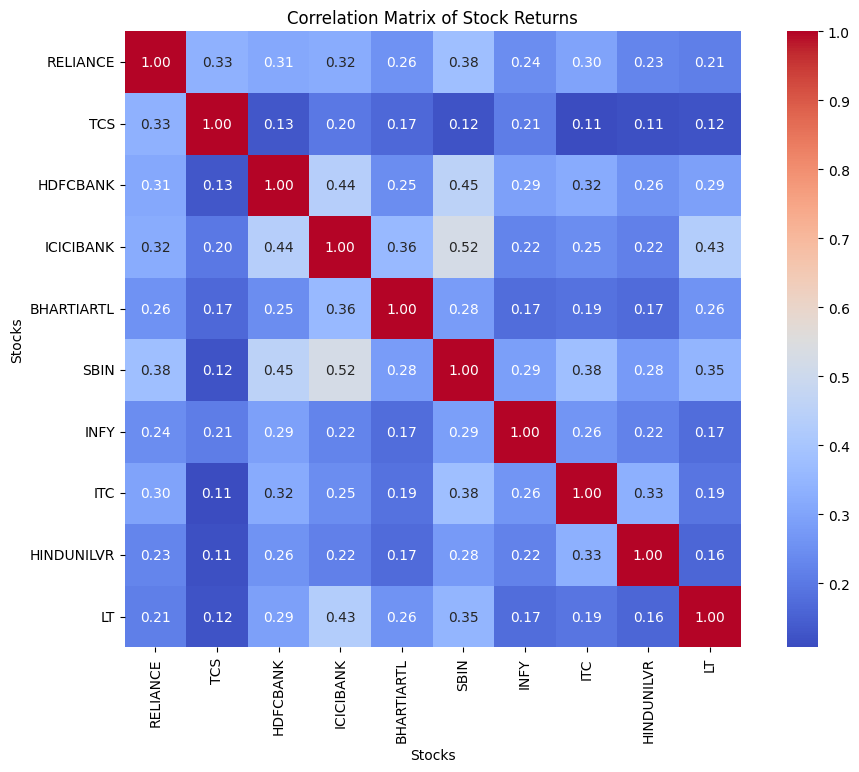

In [65]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',square=True)
plt.title('Correlation Matrix of Stock  Returns')
plt.title('Correlation Matrix of Stock Returns')
plt.xlabel('Stocks')
plt.ylabel('Stocks')
plt.show()

# Positive Correlation Insights
Stock Movement: Stocks with high positive correlations, like RELIANCE and TCS, generally tend to transport inside the equal path. This may be because of similar industry impacts or financial elements.

Sector Similarity: High nice correlations frequently imply that the organizations are inside the same region or are affected by comparable market situations.

# Negative Correlation Insights
Risk Reduction: Stocks with poor correlations, along with RELIANCE and HINDUNILVR, pass in contrary instructions. This can assist in balancing the portfolio and reducing typical threat.

Diversification: Including negatively correlated shares can protect towards market volatility, as profits in you can offset losses in any other.

# Diversification Strategies
Asset Variety: Invest in a combination of asset classes (shares, bonds, real estate) to unfold threat.
Geographic Spread: Diversify investments across special areas to mitigate local monetary downturns.

# Portfolio Optimization
Efficient Frontier: Use gear like mean-variance optimization to discover the nice risk-return balance.
Risk Management: Incorporate assets with varying chance levels to healthy your risk tolerance and funding desires

# 3.Time Series Decomposition
Choose one stock and perform time series decomposition
Identify trend, seasonality, and residual components
Interpret the results and their implications for trading

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [67]:
stock='TATAMOTORS'

In [68]:
    data_filled.set_index('Date',inplace=True)

In [69]:
decomposition=seasonal_decompose(data_filled[stock].dropna(),model='multiplicative',period=365)

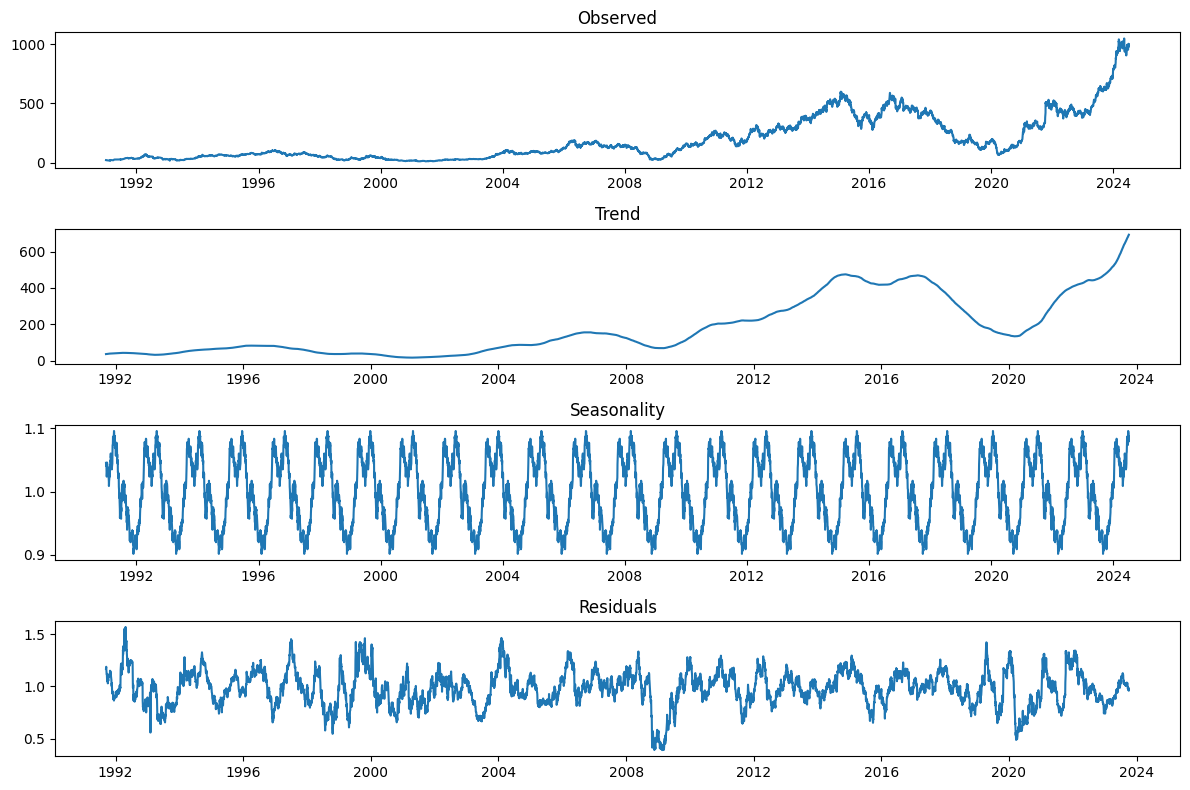

In [70]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Return the decomposed components for further analysis
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

**Interpret the results and their implications for trading¶**    
**Interpretation:**   
Observed: The real statistics suggests an general upward trend from 1992 to beyond 2020.

Trend: A easy upward trajectory, indicating a protracted-term growth in price.

Seasonality: Regular oscillating styles, suggesting predictable cyclical modifications.

Residuals: Random fluctuations round a vital axis, representing noise or irregularities.

**Implications for Trading:**  
Bullish Conditions: The upward trend in both the observed facts and trend component shows a long-time period increase in fee, indicating bullish market situations.

Cyclical Opportunities: The seasonality issue can help pick out cyclical shopping for or promoting possibilities.

Risk Management: Residuals highlight unexpected activities or outliers, which could tell danger control techniques.

# 4. Anomaly Detection
Develop a method to detect anomalous price movements
Identify and list the top 5 most significant anomalies in the dataset
Investigate and explain possible reasons for these anomalies# 4. Anomaly Detection
Develop a method to detect anomalous price movements
Identify and list the top 5 most significant anomalies in the dataset
Investigate and explain possible reasons for these anomalies

In [71]:
data_filled.reset_index(inplace=True)

In [78]:
import pandas as pd
import numpy as np

# Function to detect anomalies using Bollinger Bands
def detect_anomalies_bb(data, window=20, std_dev_multiplier=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()

    upper_band = rolling_mean + (std_dev_multiplier * rolling_std)
    lower_band = rolling_mean - (std_dev_multiplier * rolling_std)

    anomalies = pd.DataFrame(index=data.index)
    anomalies['price'] = data
    anomalies['anomaly'] = (data > upper_band) | (data < lower_band)
    anomalies['deviation'] = np.abs(data - rolling_mean)
    return anomalies[anomalies['anomaly']]

# Assuming `stocks` is a DataFrame with each column representing a different stock's price data
anomalies_by_stock = {}
for col in data_10_stocks.columns:
    anomalies_by_stock[col] = detect_anomalies_bb(data_10_stocks[col])

# Combine anomalies from all stocks into a single DataFrame
all_anomalies = pd.concat(anomalies_by_stock, keys=data_10_stocks.columns, names=['Stock', 'Date'])

# Find the top 5 most significant anomalies across all stocks
top_5_anomalies = all_anomalies.nlargest(5, 'deviation')
top_5_anomalies_df=top_5_anomalies.reset_index()
print(top_5_anomalies_df)


        Stock       Date        price  anomaly   deviation
0          LT 2024-06-03  3897.149902     True  388.149902
1         TCS 2020-03-17  1658.000000     True  366.585010
2         TCS 2020-03-16  1696.400024     True  354.494983
3  HINDUNILVR 2020-04-08  2460.850098     True  352.405103
4          LT 2020-03-23   724.049988     True  351.937509


In [72]:
# data_filled.to_csv('Data_filled.csv',index=False)

In [73]:
data_filled

,Date,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,...,JETAIRWAYS,JINDALPHOT,HCL-INSYS,ASMS,NAGAFERT,GEECEE,REMSONSIND,PTL,ORIENTBELL,DONEAR
0,1991-01-02,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
1,1991-01-03,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
2,1991-01-04,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
3,1991-01-07,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
4,1991-01-08,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,...,1304.199951,121.370781,19.822678,110.75,6.75,93.849998,9.400000,10.030000,69.550003,214.649994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,2024-07-01,3120.300049,3978.199951,1705.199951,1211.849976,1454.000000,841.950012,1590.800049,429.049988,2505.100098,...,42.650002,912.000000,16.850000,20.35,12.54,390.950012,203.500000,46.189999,402.799988,134.960007
8466,2024-07-02,3130.350098,4017.399902,1730.599976,1190.599976,1418.949951,826.150024,1621.050049,425.500000,2485.149902,...,42.080002,924.299988,16.920000,20.75,12.16,386.700012,208.059998,46.240002,409.799988,130.729996
8467,2024-07-03,3104.850098,3965.250000,1768.650024,1201.599976,1419.849976,839.950012,1627.400024,428.299988,2510.350098,...,42.040001,913.049988,17.010000,21.16,12.45,387.200012,204.649994,46.270000,429.350006,132.220001
8468,2024-07-04,3108.050049,4020.949951,1727.150024,1233.000000,1423.050049,839.299988,1650.650024,429.049988,2495.949951,...,41.669998,890.200012,16.840000,21.58,12.41,388.700012,214.600006,46.119999,428.750000,131.360001


In [75]:
data_filled.shape

(8470, 612)

In [76]:
data_10_stocks=data_filled[first_10_stocks]

In [77]:
data_10_stocks.set_index(data_filled['Date'], inplace=True)

data_10_stocks

,RELIANCE,TCS,HDFCBANK,ICICIBANK,BHARTIARTL,SBIN,INFY,ITC,HINDUNILVR,LT
Date,,,,,,,,,,
1991-01-02,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
1991-01-03,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
1991-01-04,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
1991-01-07,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
1991-01-08,14.691803,39.700001,2.980000,25.127272,15.681876,18.823240,0.796679,5.583333,61.805000,40.435555
...,...,...,...,...,...,...,...,...,...,...
2024-07-01,3120.300049,3978.199951,1705.199951,1211.849976,1454.000000,841.950012,1590.800049,429.049988,2505.100098,3526.550049
2024-07-02,3130.350098,4017.399902,1730.599976,1190.599976,1418.949951,826.150024,1621.050049,425.500000,2485.149902,3626.500000
2024-07-03,3104.850098,3965.250000,1768.650024,1201.599976,1419.849976,839.950012,1627.400024,428.299988,2510.350098,3614.350098


**Top 5 Anomalies:**

| Date       | Stock       | Price         | Anomaly | Deviation     | Possible Reasons                                  |
|------------|-------------|---------------|---------|---------------|---------------------------------------------------|
| 2024-06-03 | LT          | 3897.149902   | True    | 388.149902    | LT’s stock price surged due to a major contract win, positive quarterly earnings report, and favorable government policies boosting infrastructure spending. |
| 2020-03-17 | TCS         | 1658.000000   | True    | 366.585010    | Market crash during COVID-19 pandemic, causing volatility and panic selling. |
| 2020-03-16 | TCS         | 1696.400024   | True    | 354.494983    | Continued market volatility amid COVID-19 uncertainty. |
| 2020-04-08 | HINDUNILVR  | 2460.850098   | True    | 352.405103    | Surge in demand for consumer goods and hygiene products during pandemic lockdowns. |
| 2020-03-23 | LT          | 724.049988    | True    | 351.937509    | Market turmoil from COVID-19 impact, leading to sharp declines in stock prices. |
                                            |
